# Announcements
- Due to feedback on PS4 over the weekend, I postponed Problem Set 5 to next week.
- Please fill out anonymous poll now to give feedback on PS4!
- Solution for Lecture 16 posted on D2L, we'll go through this code in today's lecture.
- If you'd like refresher on plotting in python, [have a look at this notebook on D2L](https://d2l.arizona.edu/d2l/le/content/955328/viewContent/9517725/View) from Lecture 8.
- If you'd like a refesher on array slicing in python, [have a look at this other notebook on D2L](https://d2l.arizona.edu/d2l/le/content/955328/viewContent/9473941/View) from Lecture 4.
- __Outlook__
- - Today: intro to Boundary Value Problems (BVPs)
- - This/next week: make progress on BVPs, we need techniques to solve _non-linear and linear equations in multiple dimensions_
- - Starting late next week: BVPs for ODEs, intro to Partial Differential Equations
- Conference for Undergraduate Women in Physics: online event in 2021, [applications accepted until 10/25](https://www.aps.org/programs/women/cuwip/)

This notebook is based on notes and notebooks by Kyle T. Mandli and Vasilis Paschalidis.

Note:  The presentation below largely follows part I in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

# Solving Boundary Value Problems

## The Problem

We want to solve an ODE (PDE) that instead of having initial conditions is contained to an interval and has values at the edges of the interval.  This naturally comes about when we consider spatial problems.  One of the simplest cases for this is the Poisson problem in one-dimension
$$
    u_{xx} = f(x)
$$
where we will use the short-hand
$$
    u_{xx} = \frac{\text{d}^2 u}{\text{d} x^2} \quad \text{or} \quad \frac{\partial^2 u}{\partial x^2}.
$$

Note that due to the order of the derivative we require two conditions to solve this.  The simplest case where we are on the domain $x \in [a,b]$ is to have conditions such that we require $u(a) = u_a$ and $u(b) = u_b$ and are commonly termed boundary value problems (BVP).  If these conditions are both at one end of the domain then we can actually phrase the ODE (PDE) again as an initial value problem (IVP).  So what do we need to do to solve these types of problems?  We will consider two approaches to this problem:

1. Rephrase the BVP to an IVP and use our standard methods for ODEs.
2. Use finite differences to represent the unknowns as a linear system and solve the resulting system.

## The Shooting Method

The shooting method takes the approach that we want to use our ability to solve IVP problems and so tries to term the problem as a root finding problem for the higher order initial condition that we are not given.  This is best illustrated in an example:

Consider the problem
$$
    u_{xx} = -\sin u
$$
with
$$
    x \in [0, 2] \quad \text{and} \quad u(0) = 0.0, \quad u(2.0) = \frac{\pi}{2}.
$$

We can rewrite this problem as a system of two ODEs as
$$
    v = \begin{bmatrix} u \\ u_x \end{bmatrix} \quad \text{and} \quad v_x = \begin{bmatrix} u_x \\ u_{xx} \end{bmatrix} = \begin{bmatrix} v_2 \\ -\sin v_1 \end{bmatrix}.
$$

We know that we want $v_1(0) = 0$ but what do we use for $v_2(0)$?  Making an initial guess at $v_2(0)$ and solving the associated IVP ODE we can then find out what these initial conditions produces on the right boundary of the problem.  Using a root-finding approach (or minimization routine) we can write this procedure as
$$
    \min_{v_2(0)} \left | \pi / 2 - v_1(2) \right |
$$
where the parameter we vary is $v_2(0)$.

_While have spent more than two weeks developing integrators for this type of problem, let's use the method `integrate.ode` available in scipy today, to focus on the problem rather than array passing. The method `"dopri5"` is a specific fourth-order Runge-Kutta implementation ([see here for details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html))._

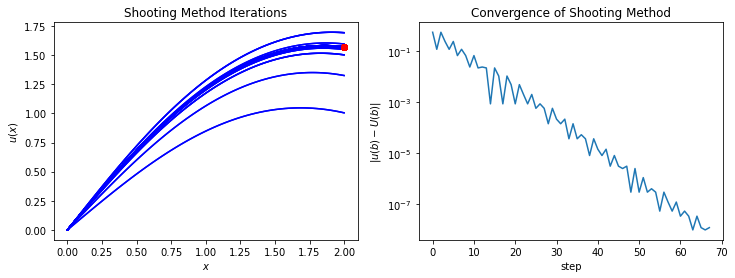

In [5]:
import numpy
import matplotlib.pyplot as plt

import scipy.integrate as integrate

# Algorithm parameters
TOLERANCE = 1e-8
MAX_ITERATIONS = 100

# Problem Statement
a = 0.0
b = 2.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = numpy.pi / 2.0
# RHS function
def f(x, u):
    return numpy.array([u[1], -numpy.sin(u[0])])

# Initial guess
# Slope at RHS
u_prime_rhs = 1.0
# Initial step size
du_prime = 0.5

# Plotting
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

# Main loop
success = False
u = numpy.empty((2, N))
convergence = numpy.zeros(MAX_ITERATIONS)
for n in range(MAX_ITERATIONS):
    
    # Initial condition
    u[0, 0] = u_a
    u[1, 0] = u_prime_rhs

    # Construct integrator
    integrator = integrate.ode(f)
    integrator.set_integrator("dopri5")
    integrator.set_initial_value(u[:, 0])

    # Compute solution - note that we are only producing the intermediate values
    # for demonstration purposes
    for (i, x_output) in enumerate(x[1:]):
        integrator.integrate(x_output)
        if not integrator.successful():
            raise Exception("Integration Failed!")
        u[:, i + 1] = integrator.y

    # Stopping Criteria
    convergence[n] = numpy.abs(u[0, -1] - u_b)
    if numpy.abs(u[0, -1] - u_b) < TOLERANCE:
        success = True
        break
    else:
        if u[0, -1] < u_b:
            u_prime_rhs += du_prime
        else:
            u_prime_rhs -= du_prime
            du_prime *= 0.5

    axes.plot(x, u[0, :], 'b')
    axes.plot(b, u_b, 'ro')

axes.set_title("Shooting Method Iterations")
axes.set_xlabel("$x$")
axes.set_ylabel("$u(x)$")

axes = fig.add_subplot(1, 2, 2)
n_range = numpy.arange(n)
axes.semilogy(n_range, convergence[:n])
axes.set_title("Convergence of Shooting Method")
axes.set_xlabel("step")
axes.set_ylabel("$|u(b) - U(b)|$")

plt.show()

The tricky part of this procedure is coming up with the search criteria, i.e. coming up with the decision of how to change $v_2(0)$ with respect to the position of $v_2(2)$ compared to what we want $u(2)$.

In general any minimization routine can be used in a shooting method.  These approaches are generally very effective at approaching non-linear BVPs. To make progress on this, we need to transfer some of the techniques you studies in algebra to numerical implementations. _More on that during the next lecture!_